In [18]:
import os
import numpy as np

from pyvi import ViTokenizer, ViPosTagger

import sklearn_crfsuite
from sklearn_crfsuite import metrics

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer

import scipy.stats

from feature.doccano2fully import *
from feature.crf_small_features import *

In [19]:
#the dataset input folder path
dataset_folder_path = 'data/input/'
# target labels
target_labels = ['type', 'brand', 'name']
# test size
test_size = 0.3

#### Data Preparing
***

In [20]:
def clean_target_label(labels):
    targets = []
    converter = lambda label : label if label in target_labels else 'None'
    targets = [converter(label) for label in labels]
    return targets

In [21]:
#return seq_in, seq_out, words_labels
def data_extracting(data_lines):
    seq_in = []
    seq_out = []
    words_labels = []

    for line in data_lines:
        line = doccano2fully(line)
        text, labels, words, tagged = extract_fully_data(line)
        labels = clean_target_label(labels)
        if tagged:
            seq_in.append(text)
            seq_out.append(labels)
            words_labels.append([(word, label) for word, label in zip(words, labels)])

    return seq_in, seq_out, words_labels

In [22]:
#return word_posteg_label
def word_postagging(seq_in, words_labels):
    words_postags_labels = []
    for seq_itr in range(len(seq_in)):
        tokens_postags = ViPosTagger.postagging(ViTokenizer.tokenize(seq_in[seq_itr]))
        words_postags = []
        for tp_itr in range(len(tokens_postags[0])):
            if "_" in tokens_postags[0][tp_itr]:
                for word in tokens_postags[0][tp_itr].split('_'):
                    words_postags.append((word,tokens_postags[1][tp_itr]))
            else:
                words_postags.append((tokens_postags[0][tp_itr],tokens_postags[1][tp_itr]))
        words_postags_labels.append([(w, pos, label) for (w, label), (word, pos) in zip(words_labels[seq_itr], words_postags)])
        #break
    return words_postags_labels

In [23]:
# A function for extracting features in documents
def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

# A function fo generating the list of labels for each document
def sent2labels(sent):
    return [label for (token, postag, label) in sent]

In [24]:
def file2dataset(input_file_name):
    input_file_path = dataset_folder_path + input_file_name
    input_file = open(input_file_path, "r", encoding = "utf8")
    
    data_lines = input_file.readlines()
    input_file.close()
    
    seq_in, seq_out, words_labels = data_extracting(data_lines)
    words_postags_labels = word_postagging(seq_in, words_labels)

    # to features
    X = [sent2features(sent) for sent in words_postags_labels]
    y = [sent2labels(sent) for sent in words_postags_labels]

    # split to training set and testing set
    indices = np.arange(len(words_postags_labels))
    X_train_small, X_test_small, y_train_small, y_test_small, idx1, idx2 = train_test_split(X, y, indices, test_size=test_size, random_state=42)
    
    return X_train_small, X_test_small, y_train_small, y_test_small

In [25]:
#list of input files
input_files = os.scandir(dataset_folder_path)
input_file_names = [input_file.name for input_file in input_files]

#dataset preparing
X_train = []
X_test = []
y_train = []
y_test = []

for input_file_name in input_file_names:
    X_train_small, X_test_small, y_train_small, y_test_small = file2dataset(input_file_name)
    X_train += X_train_small
    X_test += X_test_small
    y_train += y_train_small
    y_test += y_test_small

print("Train set: ", len(X_train))
print("Test set: ", len(X_test))


Train set:  5895
Test set:  2532


#### Training and Testing
***

In [26]:
%%time
# Training 

#___ using sklearn
crf = sklearn_crfsuite.CRF(
    algorithm = 'lbfgs',
    c1= 0.1,
    c2= 0.01,
    max_iterations= 8000,
    epsilon= 0.00000010,
    delta= 0.00000010,
    min_freq= 3,
    all_possible_transitions= True,
)

crf.fit(X_train, y_train)


Wall time: 2min 44s


C:\Users\Green\miniconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.1, c2=0.01,
    delta=1e-07, epsilon=1e-07, keep_tempfiles=None, max_iterations=8000,
    min_freq=3)

In [27]:
%%time
# Predict
labels = list(crf.classes_)
labels.remove('None')

y_train_pred = crf.predict(X_train)
y_pred = crf.predict(X_test)

print(metrics.flat_f1_score(y_test, y_pred,
                      average='weighted', labels=labels))

0.7856585498648336
Wall time: 1 s


In [28]:
# Training Metrics 
sorted_labels = sorted(
    labels,
key=lambda name: (name[1:], name[0]) )
print(metrics.flat_classification_report(
    y_train, y_train_pred, labels=sorted_labels, digits=3
))


C:\Users\Green\miniconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass labels=['name', 'brand', 'type'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


              precision    recall  f1-score   support

        name      0.896     0.875     0.885      5940
       brand      0.886     0.826     0.855      3031
        type      0.924     0.907     0.916     16236

   micro avg      0.913     0.890     0.901     25207
   macro avg      0.902     0.869     0.885     25207
weighted avg      0.913     0.890     0.901     25207



In [29]:
# Testing Metrics 
sorted_labels = sorted(
    labels,
key=lambda name: (name[1:], name[0]) )
print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))


              precision    recall  f1-score   support

        name      0.733     0.695     0.714      2519
       brand      0.717     0.652     0.683      1276
        type      0.834     0.829     0.832      6802

   micro avg      0.797     0.776     0.787     10597
   macro avg      0.761     0.725     0.743     10597
weighted avg      0.796     0.776     0.786     10597



# Hyperparameters Optimize

In [30]:
%%time
# define fixed parameters and parameters to search

crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    max_iterations=100,
    all_possible_transitions=True
)

params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
}

# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_recall_score,
                        average='weighted', labels=labels)

# search
rs = RandomizedSearchCV(crf, params_space,
                        cv=3,
                        verbose=1,
                        n_jobs=-1,
                        n_iter=50,
                        scoring=f1_scorer)
rs.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   54.9s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  3.6min finished


Wall time: 3min 43s


RandomizedSearchCV(cv=3,
                   estimator=CRF(algorithm='lbfgs',
                                 all_possible_transitions=True,
                                 keep_tempfiles=None, max_iterations=100),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'c1': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000249C37A9100>,
                                        'c2': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000249C3AA4490>},
                   scoring=make_scorer(flat_recall_score, average=weighted, labels=['type', 'brand', 'name']),
                   verbose=1)

In [31]:
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)
print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

best params: {'c1': 0.20911232427317195, 'c2': 0.012046229744645188}
best CV score: 0.4765040639952176
model size: 1.35M


Dark blue => 0.3706, dark red => 0.4765


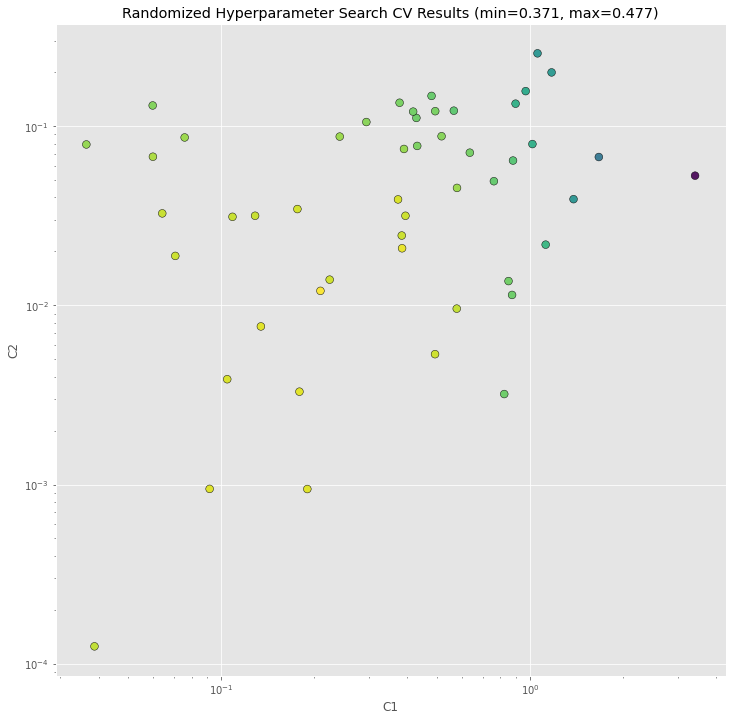

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Randomized Hyperparameter Search CV Results

_x = [s['c1'] for s in rs.cv_results_['params'] ]
_y = [s['c2'] for s in rs.cv_results_['params'] ]
_c = [s for s in rs.cv_results_['mean_test_score']]

fig = plt.figure()
fig.set_size_inches(12, 12)
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('C1')
ax.set_ylabel('C2')
ax.set_title("Randomized Hyperparameter Search CV Results (min={:0.3}, max={:0.3})".format(
    min(_c), max(_c)
))

ax.scatter(_x, _y, c=_c, s=60, alpha=0.9, edgecolors=[0,0,0])

print("Dark blue => {:0.4}, dark red => {:0.4}".format(min(_c), max(_c)))

In [33]:
# Best estimator model
best_crf = rs.best_estimator_

# best estimator for training set
y_pred2 = best_crf.predict(X_train)
print("# Training metrics: \n")
print(metrics.flat_classification_report(
    y_train, y_pred2, labels=labels, digits=3
))

print("\n ---------------------------------------------------- \n")

# best estimator for testing set
y_pred = best_crf.predict(X_test)
print("# Testing metrics: \n")
print(metrics.flat_classification_report(
    y_test, y_pred, labels=labels, digits=3
))

# Training metrics: 



C:\Users\Green\miniconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass labels=['type', 'brand', 'name'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


              precision    recall  f1-score   support

        type      0.950     0.934     0.942     16236
       brand      0.980     0.974     0.977      3031
        name      0.989     0.986     0.987      5940

   micro avg      0.963     0.951     0.957     25207
   macro avg      0.973     0.965     0.969     25207
weighted avg      0.963     0.951     0.957     25207


 ---------------------------------------------------- 

# Testing metrics: 

              precision    recall  f1-score   support

        type      0.846     0.833     0.840      6802
       brand      0.777     0.653     0.710      1276
        name      0.762     0.659     0.707      2519

   micro avg      0.820     0.770     0.794     10597
   macro avg      0.795     0.715     0.752     10597
weighted avg      0.818     0.770     0.792     10597

